<a href="https://colab.research.google.com/github/tfjonas/ggnn_fault_loc/blob/master/ggnn_fault_loc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!git clone https://$GITHUB_AUTH@github.com/tfjonas/ggnn_fault_loc.git

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np

In [16]:
folder = 'dataset/'
TrainDataset = torch.load(folder + 'train_dataset_050503.pt')
TestDataset = torch.load(folder + 'test_dataset_050503.pt')
#UnrelatedDataset = torch.load('unrelated_dataset_rev6.pt')

adj_matrices = torch.load(folder + 'adj_matrices_050503.pt')
dist_matrices = torch.load(folder + 'dist_matrices_050503.pt')

In [4]:
from model import GGNN

In [5]:
INPUTS = 1
PROPAG_STEPS = 15
HIDDEN_LAYER = 8
model = GGNN.GGNNModel(INPUTS, HIDDEN_LAYER, PROPAG_STEPS).cuda()

In [6]:
BATCH_SIZE = 15

trainLoader = torch.utils.data.DataLoader(TrainDataset, batch_size=BATCH_SIZE, shuffle=True)
TestLoader = torch.utils.data.DataLoader(TestDataset, batch_size=BATCH_SIZE, shuffle=True)

classes = (0,1,2)


In [7]:
import torch.nn as nn

criterion_1 = nn.NLLLoss()
criterion_2 = nn.CrossEntropyLoss()
criterion_3 = nn.PoissonNLLLoss()

optimizer = torch.optim.Adam(model.parameters())

In [8]:
STEPS_PER_EPOCH = int((len(TrainDataset)/BATCH_SIZE) * 3)
STEPS_PER_EPOCH

522

In [9]:
TrainDataset[0]

(tensor([[0.0898],
         [0.0898],
         [0.0622],
         [0.0924],
         [0.1667],
         [0.1294],
         [0.1295],
         [0.1000]], dtype=torch.float64),
 tensor(0),
 tensor(1))

In [10]:
import time


In [11]:

start_time = time.time()

EPOCHS = 100
epoch_loss = []
loss_ls = []
predict = []
acc = []
lss = []
for epoch in range(EPOCHS):
    model.train()
    acc_ep = []
    loss_ep = []
    for step in range(STEPS_PER_EPOCH):
        # Get batch data
        X, T, idx = next(iter(trainLoader))
        A = adj_matrices[idx]
        # Forward pass: Compute predicted y by passing x to the model
        Y = model(X.cuda(), A.cuda())
        # Compute loss
        loss = criterion_2(Y, T.cuda())

        predictions = torch.exp(Y).argmax(-1)
        #print('EPOCH: ', epoch)
        #print('Y', predictions)       
        #print('T', T)
        #print('Loss', loss)
        #print('\n')

        aux = 0
        for j in range(len(T)):

            if T[j].item() == predictions[j].item():
                aux += 1

        #print('Acc:', aux/len(T))

        acc_ep.append(aux/len(T))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
        loss_ls.append(loss.item())

        loss_ep.append(loss.item())

        predict.append(torch.exp(Y).argmax(-1))
    acc.append(np.array(acc_ep).mean())
    lss.append(np.array(loss_ep).mean())
    statistics = {'loss_ls': loss_ls, 'accuracy': acc}
    print('EPOCH: ', epoch+1)
    print("--- %s mins ---" % round(((time.time() - start_time)/60),1))
    print('\n')

EPOCH:  1
--- 0.2 mins ---


EPOCH:  2
--- 0.4 mins ---


EPOCH:  3
--- 0.5 mins ---


EPOCH:  4
--- 0.7 mins ---


EPOCH:  5
--- 0.9 mins ---


EPOCH:  6
--- 1.1 mins ---


EPOCH:  7
--- 1.2 mins ---


EPOCH:  8
--- 1.4 mins ---


EPOCH:  9
--- 1.6 mins ---


EPOCH:  10
--- 1.8 mins ---


EPOCH:  11
--- 2.0 mins ---


EPOCH:  12
--- 2.1 mins ---


EPOCH:  13
--- 2.3 mins ---


EPOCH:  14
--- 2.5 mins ---


EPOCH:  15
--- 2.7 mins ---


EPOCH:  16
--- 2.9 mins ---


EPOCH:  17
--- 3.1 mins ---


EPOCH:  18
--- 3.2 mins ---


EPOCH:  19
--- 3.4 mins ---


EPOCH:  20
--- 3.6 mins ---


EPOCH:  21
--- 3.8 mins ---


EPOCH:  22
--- 4.0 mins ---


EPOCH:  23
--- 4.2 mins ---


EPOCH:  24
--- 4.3 mins ---


EPOCH:  25
--- 4.5 mins ---


EPOCH:  26
--- 4.7 mins ---


EPOCH:  27
--- 4.9 mins ---


EPOCH:  28
--- 5.1 mins ---


EPOCH:  29
--- 5.3 mins ---


EPOCH:  30
--- 5.4 mins ---


EPOCH:  31
--- 5.6 mins ---


EPOCH:  32
--- 5.8 mins ---


EPOCH:  33
--- 6.0 mins ---


EPOCH:  34
--- 6.2 

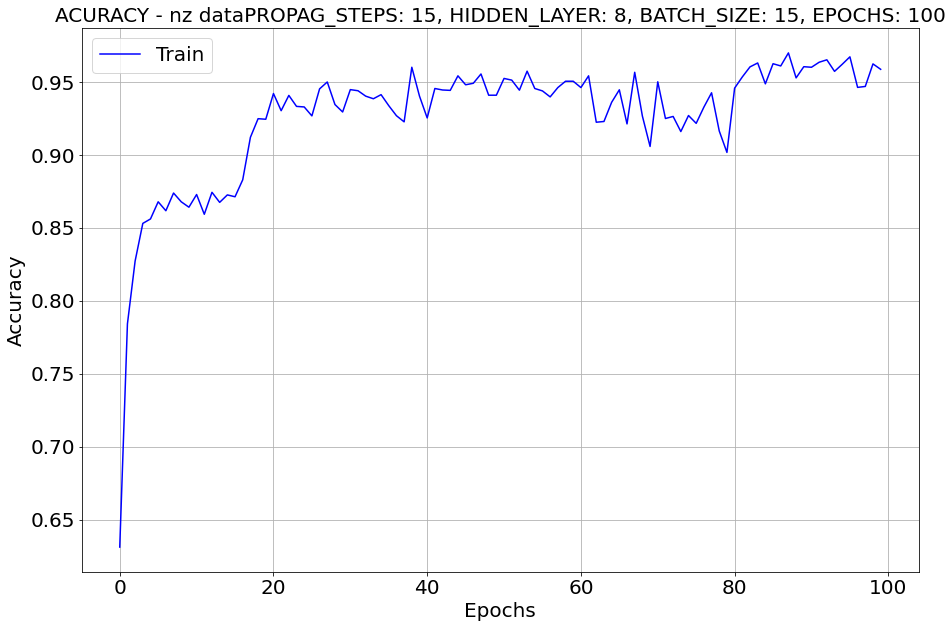

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

name = 'PROPAG_STEPS: {}, HIDDEN_LAYER: {}, BATCH_SIZE: {}, EPOCHS: {}'


plt.subplots(figsize=(15, 10))
plt.plot(acc, color='b', label='Train')
#plt.plot(lss, color='r', label='Loss')
#plt.plot(acc_t, color='r', label='Test')
plt.grid()
plt.title('ACURACY - nz data' + name .format(PROPAG_STEPS, HIDDEN_LAYER, BATCH_SIZE, EPOCHS ))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=25)  # fontsize of the figure title

plt.savefig(folder + 'Accuracy - d11_12 (8).png')

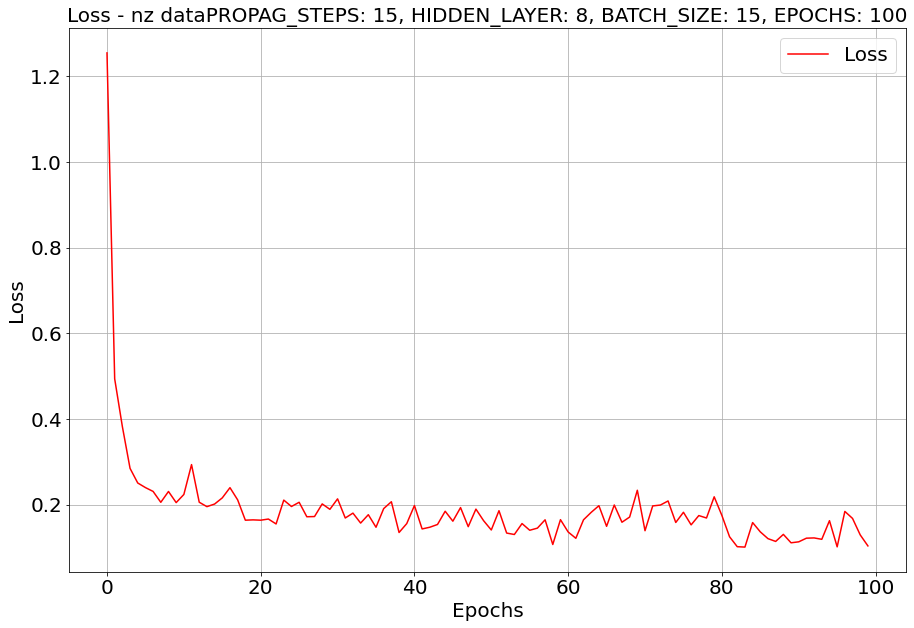

In [19]:
plt.subplots(figsize=(15, 10))
#plt.plot(acc, color='b', label='Train')
plt.plot(lss, color='r', label='Loss')
#plt.plot(acc_t, color='r', label='Test')
plt.grid()
plt.title('Loss - nz data' + name .format(PROPAG_STEPS, HIDDEN_LAYER, BATCH_SIZE, EPOCHS ))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.rc('font', size=20)          # controls default text sizes
plt.rc('axes', titlesize=20)     # fontsize of the axes title
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=20)    # fontsize of the tick labels
plt.rc('ytick', labelsize=20)    # fontsize of the tick labels
plt.rc('legend', fontsize=20)    # legend fontsize
plt.rc('figure', titlesize=25)  # fontsize of the figure title

plt.savefig(folder + 'Loss - d11_12 nz (8).png')

In [ ]:
'''
# Test

epoch_loss_t = []
loss_ls_t = []
predict_t = []
acc_t = []
lss_t = []

for epoch in range(EPOCHS):
    model.eval()
    acc_ep_t = []
    loss_ep_t = []
    for batch in TestLoader:
        X, T, idx = batch
        A = adj_matrices[idx]
        D = dist_matrices[idx]
        Y = model(X.cuda(), A.cuda()) 
        
        loss_t = criterion_2(Y, T.cuda())
        
        predictions_t = torch.exp(Y).argmax(-1)
        aux_t = 0
        for j in range(len(T)):
            
            if T[j].item() == predictions_t[j].item():
                aux_t += 1
        #print('Acc:', aux_t/len(T))
        acc_ep_t.append(aux_t/len(T))
        
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        epoch_loss_t.append(loss_t.item())
        loss_ls_t.append(loss_t.item())
        
        loss_ep_t.append(loss_t.item())

        predict_t.append(torch.exp(Y).argmax(-1))
    acc_t.append(np.array(acc_ep_t).mean())
    lss_t.append(np.array(loss_ep_t).mean())
    print('EPOCH: ', epoch)
'''